In [ ]:
import os
import gzip
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoTokenizer, AutoModel

In [ ]:
# Dataset URLs
train_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
test_url  = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"
imdb_url  = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"

# Load datasets
train_df = pd.read_csv(train_url, sep='\t', header=None, names=['sentence', 'label'])
test_df  = pd.read_csv(test_url, sep='\t', header=None, names=['sentence', 'label'])
imdb_df  = pd.read_csv(imdb_url)

print("SST2 Train shape:", train_df.shape)
print("SST2 Test shape:", test_df.shape)
print("IMDB shape:", imdb_df.shape)

# Split SST2 training into training and validation sets (80%-20% split)
train_data_df, val_data_df = train_test_split(train_df, test_size=0.2, random_state=42)

SST2 Train shape: (6920, 2)
SST2 Test shape: (1821, 2)
IMDB shape: (50000, 2)


In [ ]:
# Initialize CountVectorizer with max_features=10000
vectorizer = CountVectorizer(max_features=10000)
X_train_bow = vectorizer.fit_transform(train_data_df['sentence']).toarray()
X_val_bow   = vectorizer.transform(val_data_df['sentence']).toarray()
X_test_bow  = vectorizer.transform(test_df['sentence']).toarray()

y_train_bow = train_data_df['label'].values
y_val_bow   = val_data_df['label'].values
y_test_bow  = test_df['label'].values

# Helper: create a DataLoader from numpy arrays
def create_loader(X, y, batch_size=32, shuffle=True):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                            torch.tensor(y, dtype=torch.long))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader_bow = create_loader(X_train_bow, y_train_bow)
val_loader_bow   = create_loader(X_val_bow, y_val_bow)
test_loader_bow  = create_loader(X_test_bow, y_test_bow)

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes=[512, 256, 128, 64], output_size=2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.out = nn.Linear(hidden_sizes[3], output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        return self.out(x)

# Create a BOW model (input size = 10000) and print trainable parameter count.
model_bow = SentimentClassifier(input_size=10000)
num_params = sum(p.numel() for p in model_bow.parameters() if p.requires_grad)
print("BOW Model trainable parameters:", num_params)

BOW Model trainable parameters: 5293122


In [ ]:
writer_bow = SummaryWriter(log_dir="runs/BOW_experiment")
optimizer = optim.Adam(model_bow.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10
best_val_acc = 0.0

for epoch in range(epochs):
    # Training Phase
    model_bow.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    for inputs, labels in train_loader_bow:
        optimizer.zero_grad()
        outputs = model_bow(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()
        total_samples += labels.size(0)
    train_loss = total_loss / total_samples
    train_acc = total_correct / total_samples

    # Validation Phase
    model_bow.eval()
    val_loss, val_correct, val_samples = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader_bow:
            outputs = model_bow(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_samples += labels.size(0)
    val_loss /= val_samples
    val_acc = val_correct / val_samples

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    writer_bow.add_scalar('Train Loss', train_loss, epoch)
    writer_bow.add_scalar('Val Loss', val_loss, epoch)
    writer_bow.add_scalar('Train Acc', train_acc, epoch)
    writer_bow.add_scalar('Val Acc', val_acc, epoch)

    # Save best checkpoint (for resume training)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_bow.state_dict(), "checkpoint_bow.pt")
        print("Saved best BOW checkpoint.")

writer_bow.close()

# Compress the BOW checkpoint
with open("checkpoint_bow.pt", "rb") as f_in, gzip.open("checkpoint_bow.pt.gz", "wb") as f_out:
    shutil.copyfileobj(f_in, f_out)
print("BOW checkpoint compressed.")

Epoch 1/10 | Train Loss: 0.5888, Train Acc: 67.96% | Val Loss: 0.4577, Val Acc: 77.82%
Saved best BOW checkpoint.
Epoch 2/10 | Train Loss: 0.2541, Train Acc: 89.76% | Val Loss: 0.4929, Val Acc: 80.13%
Saved best BOW checkpoint.
Epoch 3/10 | Train Loss: 0.0660, Train Acc: 97.63% | Val Loss: 0.7663, Val Acc: 79.84%
Epoch 4/10 | Train Loss: 0.0174, Train Acc: 99.48% | Val Loss: 1.2938, Val Acc: 78.97%
Epoch 5/10 | Train Loss: 0.0059, Train Acc: 99.84% | Val Loss: 1.6732, Val Acc: 80.06%
Epoch 6/10 | Train Loss: 0.0067, Train Acc: 99.82% | Val Loss: 1.4606, Val Acc: 79.26%
Epoch 7/10 | Train Loss: 0.0074, Train Acc: 99.77% | Val Loss: 1.7040, Val Acc: 77.67%
Epoch 8/10 | Train Loss: 0.0070, Train Acc: 99.82% | Val Loss: 1.5660, Val Acc: 79.12%
Epoch 9/10 | Train Loss: 0.0022, Train Acc: 99.96% | Val Loss: 1.6943, Val Acc: 78.97%
Epoch 10/10 | Train Loss: 0.0026, Train Acc: 99.91% | Val Loss: 1.9111, Val Acc: 77.67%
BOW checkpoint compressed.


In [ ]:
# Define a BERTEmbedder class using distilbert-base-uncased for lighter processing.
class BERTEmbedder:
    def __init__(self, model_name='distilbert-base-uncased'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.embedding_size = self.model.config.hidden_size

    def get_embeddings(self, sentences, sample_limit=200):
        # Limit to sample_limit samples to ease computation.
        if len(sentences) > sample_limit:
            sentences = sentences[:sample_limit]
        inputs = self.tokenizer(sentences, return_tensors='pt', padding=True, truncation=True, max_length=128)
        # Use mixed precision if CUDA is available.
        if torch.cuda.is_available():
            with torch.cuda.amp.autocast():
                inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
                outputs = self.model(**inputs)
        else:
            inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = self.model(**inputs)
        # Return the mean of the last hidden state as the sentence embedding.
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# Initialize the embedder.
embedder = BERTEmbedder()

# Gather embeddings for at most 200 samples per split.
X_train_embed = embedder.get_embeddings(train_data_df['sentence'].tolist(), sample_limit=200)
X_val_embed   = embedder.get_embeddings(val_data_df['sentence'].tolist(), sample_limit=200)
X_test_embed  = embedder.get_embeddings(test_df['sentence'].tolist(), sample_limit=200)

# Adjust labels to match the number of samples.
y_train_embed = train_data_df['label'].values[:len(X_train_embed)]
y_val_embed   = val_data_df['label'].values[:len(X_val_embed)]
y_test_embed  = test_df['label'].values[:len(X_test_embed)]

# Create DataLoaders for embeddings.
train_loader_embed = create_loader(X_train_embed, y_train_embed)
val_loader_embed   = create_loader(X_val_embed, y_val_embed)
test_loader_embed  = create_loader(X_test_embed, y_test_embed)

# Create an embeddings-based model (input size from embedder).
model_embed = SentimentClassifier(input_size=embedder.embedding_size)
print("BERT Embedding Model trainable parameters:",
      sum(p.numel() for p in model_embed.parameters() if p.requires_grad))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

BERT Embedding Model trainable parameters: 566338


In [ ]:
writer_embed = SummaryWriter(log_dir="runs/BERT_experiment")
optimizer_embed = optim.Adam(model_embed.parameters(), lr=0.001)
best_val_acc_embed = 0.0

for epoch in range(epochs):
    model_embed.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    for inputs, labels in train_loader_embed:
        optimizer_embed.zero_grad()
        outputs = model_embed(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_embed.step()
        total_loss += loss.item() * inputs.size(0)
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()
        total_samples += labels.size(0)
    train_loss = total_loss / total_samples
    train_acc = total_correct / total_samples

    model_embed.eval()
    val_loss, val_correct, val_samples = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader_embed:
            outputs = model_embed(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_samples += labels.size(0)
    val_loss /= val_samples
    val_acc = val_correct / val_samples

    print(f"BERT Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    writer_embed.add_scalar('Train Loss', train_loss, epoch)
    writer_embed.add_scalar('Val Loss', val_loss, epoch)
    writer_embed.add_scalar('Train Acc', train_acc, epoch)
    writer_embed.add_scalar('Val Acc', val_acc, epoch)

    if val_acc > best_val_acc_embed:
        best_val_acc_embed = val_acc
        torch.save(model_embed.state_dict(), "checkpoint_embed.pt")
        print("Saved best BERT checkpoint.")

writer_embed.close()

with open("checkpoint_embed.pt", "rb") as f_in, gzip.open("checkpoint_embed.pt.gz", "wb") as f_out:
    shutil.copyfileobj(f_in, f_out)
print("BERT checkpoint compressed.")

BERT Epoch 1/10 | Train Loss: 0.6926, Train Acc: 53.00% | Val Loss: 0.6923, Val Acc: 48.50%
Saved best BERT checkpoint.
BERT Epoch 2/10 | Train Loss: 0.6831, Train Acc: 55.00% | Val Loss: 0.6717, Val Acc: 62.50%
Saved best BERT checkpoint.
BERT Epoch 3/10 | Train Loss: 0.6391, Train Acc: 71.00% | Val Loss: 0.6088, Val Acc: 72.00%
Saved best BERT checkpoint.
BERT Epoch 4/10 | Train Loss: 0.5226, Train Acc: 82.00% | Val Loss: 0.5340, Val Acc: 73.00%
Saved best BERT checkpoint.
BERT Epoch 5/10 | Train Loss: 0.4656, Train Acc: 77.50% | Val Loss: 0.5451, Val Acc: 73.00%
BERT Epoch 6/10 | Train Loss: 0.4064, Train Acc: 83.50% | Val Loss: 0.6046, Val Acc: 71.50%
BERT Epoch 7/10 | Train Loss: 0.2848, Train Acc: 89.50% | Val Loss: 0.6731, Val Acc: 74.50%
Saved best BERT checkpoint.
BERT Epoch 8/10 | Train Loss: 0.3822, Train Acc: 84.00% | Val Loss: 0.6830, Val Acc: 72.00%
BERT Epoch 9/10 | Train Loss: 0.2467, Train Acc: 90.50% | Val Loss: 0.5437, Val Acc: 78.00%
Saved best BERT checkpoint.
BERT

In [ ]:
# Prepare the IMDB dataset: shuffle, map sentiments, and rename review column to 'sentence'
imdb_df = imdb_df.sample(frac=1, random_state=42).reset_index(drop=True)
imdb_df['label'] = imdb_df['sentiment'].map({'positive': 1, 'negative': 0})
imdb_df = imdb_df[['review', 'label']].rename(columns={'review': 'sentence'})
imdb_train_df, imdb_val_df = train_test_split(imdb_df, test_size=0.2, random_state=42)

# Preprocess IMDB texts using a new CountVectorizer
imdb_vectorizer = CountVectorizer(max_features=10000)
X_imdb_train = imdb_vectorizer.fit_transform(imdb_train_df['sentence']).toarray()
X_imdb_val   = imdb_vectorizer.transform(imdb_val_df['sentence']).toarray()
y_imdb_train = imdb_train_df['label'].values
y_imdb_val   = imdb_val_df['label'].values

imdb_train_loader = create_loader(X_imdb_train, y_imdb_train)
imdb_val_loader   = create_loader(X_imdb_val, y_imdb_val)

# Create a model for IMDB (BOW-based; input size = 10000)
model_imdb = SentimentClassifier(input_size=10000)

# Resume training: load the best checkpoint from BOW training if available
resume_training = True
if resume_training and os.path.exists("checkpoint_bow.pt"):
    model_imdb.load_state_dict(torch.load("checkpoint_bow.pt"))
    print("Resumed training from checkpoint_bow.pt for IMDB.")

Resumed training from checkpoint_bow.pt for IMDB.


<ipython-input-8-0cf1b5b428e0>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_imdb.load_state_dict(torch.load("checkpoint_bow.pt"))


In [ ]:
writer_imdb = SummaryWriter(log_dir="runs/IMDB_experiment")
optimizer_imdb = optim.Adam(model_imdb.parameters(), lr=0.0001)  # Smaller LR for continual learning
best_val_acc_imdb = 0.0

for epoch in range(epochs):
    model_imdb.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    for inputs, labels in imdb_train_loader:
        optimizer_imdb.zero_grad()
        outputs = model_imdb(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_imdb.step()
        total_loss += loss.item() * inputs.size(0)
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()
        total_samples += labels.size(0)
    train_loss = total_loss / total_samples
    train_acc = total_correct / total_samples

    model_imdb.eval()
    val_loss, val_correct, val_samples = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in imdb_val_loader:
            outputs = model_imdb(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_samples += labels.size(0)
    val_loss /= val_samples
    val_acc = val_correct / val_samples

    print(f"IMDB Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    writer_imdb.add_scalar('Train Loss', train_loss, epoch)
    writer_imdb.add_scalar('Val Loss', val_loss, epoch)
    writer_imdb.add_scalar('Train Acc', train_acc, epoch)
    writer_imdb.add_scalar('Val Acc', val_acc, epoch)

    if val_acc > best_val_acc_imdb:
        best_val_acc_imdb = val_acc
        torch.save(model_imdb.state_dict(), "checkpoint_imdb.pt")
        print("Saved best IMDB checkpoint.")

writer_imdb.close()

with open("checkpoint_imdb.pt", "rb") as f_in, gzip.open("checkpoint_imdb.pt.gz", "wb") as f_out:
    shutil.copyfileobj(f_in, f_out)
print("IMDB checkpoint compressed.")

IMDB Epoch 1/10 | Train Loss: 0.9002, Train Acc: 67.56% | Val Loss: 0.3191, Val Acc: 87.60%
Saved best IMDB checkpoint.
IMDB Epoch 2/10 | Train Loss: 0.2891, Train Acc: 88.92% | Val Loss: 0.2588, Val Acc: 89.68%
Saved best IMDB checkpoint.
IMDB Epoch 3/10 | Train Loss: 0.2097, Train Acc: 92.02% | Val Loss: 0.2540, Val Acc: 90.26%
Saved best IMDB checkpoint.
IMDB Epoch 4/10 | Train Loss: 0.1515, Train Acc: 94.33% | Val Loss: 0.3233, Val Acc: 89.69%
IMDB Epoch 5/10 | Train Loss: 0.0922, Train Acc: 96.87% | Val Loss: 0.3709, Val Acc: 89.46%
IMDB Epoch 6/10 | Train Loss: 0.0477, Train Acc: 98.53% | Val Loss: 0.4749, Val Acc: 89.03%
IMDB Epoch 7/10 | Train Loss: 0.0268, Train Acc: 99.14% | Val Loss: 0.5617, Val Acc: 89.11%
IMDB Epoch 8/10 | Train Loss: 0.0177, Train Acc: 99.45% | Val Loss: 0.6268, Val Acc: 89.32%
IMDB Epoch 9/10 | Train Loss: 0.0144, Train Acc: 99.57% | Val Loss: 0.6066, Val Acc: 89.01%
IMDB Epoch 10/10 | Train Loss: 0.0103, Train Acc: 99.72% | Val Loss: 0.6419, Val Acc: 89

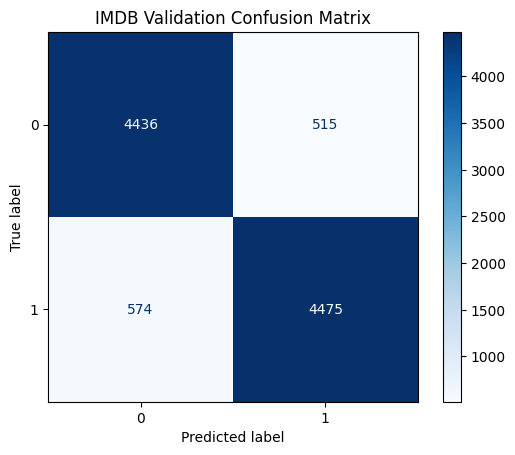

In [ ]:
model_imdb.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in imdb_val_loader:
        outputs = model_imdb(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("IMDB Validation Confusion Matrix")
plt.show()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=runs/